## Summary

L'objectif est de construire un modèle de classification capable de **prédire si une personne gagne plus ou moins de 50 000 dollars par an**, en utilisant ses caractéristiques socio-démographiques.

Le jeu de données est **"Adult Income"** du [UCI Machine Learning Repository](https://archive.ics.uci.edu/).

- **[UCIMLREPO](https://github.com/uci-ml-repo/ucimlrepo) package**

Le package UCIMLRepo (pour **UCI Machine Learning Repository**) est une **bibliothèque Python** qui facilite l’accès aux jeux de données disponibles sur le célèbre dépôt [UCI Machine Learning Repository](https://archive.ics.uci.edu/). Il permet de **chercher, télécharger et utiliser facilement ces datasets directement dans un notebook Python**, sans avoir à passer par un téléchargement manuel.

## Packages

In [1]:
pip install dill imblearn pendulum ucimlrepo yellowbrick loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.7/353.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.0 MB/s eta 0:00:00


In [2]:
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from ucimlrepo import fetch_ucirepo, list_available_datasets
from yellowbrick.classifier import DiscriminationThreshold

set_config(display='diagram')
pd.set_option("display.max_columns", None)

## Settings

In [3]:
EXECUTION_DATE = pendulum.now(tz="UTC")


ROOT_DIR = Path().cwd()
MODEL_DIR = Path(ROOT_DIR, "models")

MODEL_DIR.mkdir(parents=True, exist_ok=True)
logger.info(f"Model directory: {MODEL_DIR}")

2025-05-06 08:28:23.583 | INFO     | __main__:<cell line: 0>:8 - Model directory: /content/models


## Data collection

In [4]:
# check which datasets can be imported
list_available_datasets()

-------------------------------------
The following datasets are available:
-------------------------------------
Dataset Name                                                                            ID    
------------                                                                            --    
Abalone                                                                                 1     
Adult                                                                                   2     
Annealing                                                                               3     
Audiology (Standardized)                                                                8     
Auto MPG                                                                                9     
Automobile                                                                              10    
Balance Scale                                                                           12    
Balloons                       

In [5]:
# fetch dataset
adult = fetch_ucirepo(name="Adult", id=None)

# fetch data
data = adult.data.original

logger.info(f"{data.shape}")

2025-05-06 08:28:25.538 | INFO     | __main__:<cell line: 0>:7 - (48842, 15)


In [6]:
data.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [7]:
# metadata
logger.info(f"Metadata \n {adult.metadata}")

# variable information
logger.info(f"Features: \n{adult.variables}")

2025-05-06 08:28:25.886 | INFO     | __main__:<cell line: 0>:2 - Metadata 
 {'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Cen

In [8]:
data.describe(include="all")

age workclass        fnlwgt education  education-num  \
count   48842.000000     47879  4.884200e+04     48842   48842.000000   
unique           NaN         9           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     33906           NaN     15784            NaN   
mean       38.643585       NaN  1.896641e+05       NaN      10.078089   
std        13.710510       NaN  1.056040e+05       NaN       2.570973   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%        28.000000       NaN  1.175505e+05       NaN       9.000000   
50%        37.000000       NaN  1.781445e+05       NaN      10.000000   
75%        48.000000       NaN  2.376420e+05       NaN      12.000000   
max        90.000000       NaN  1.490400e+06       NaN      16.000000   

            marital-status      occupation relationship   race    sex  \
count                48842           47876        48842  48842  48842   
unique                   7              15            6      5      2   
top     Married-civ-spouse  Prof-specialty      Husband  White   Male   
freq                 22379            6172        19716  41762  32650   
mean                   NaN             NaN          NaN    NaN    NaN   
std                    NaN             NaN          NaN    NaN    NaN   
min                    NaN             NaN          NaN    NaN    NaN   
25%                    NaN             NaN          NaN    NaN    NaN   
50%                    NaN             NaN          NaN    NaN    NaN   
75%                    NaN             NaN          NaN    NaN    NaN   
max                    NaN             NaN          NaN    NaN    NaN   

        capital-gain  capital-loss  hours-per-week native-country income  
count   48842.000000  48842.000000    48842.000000          48568  48842  
unique           NaN           NaN             NaN             42      4  
top              NaN           NaN             NaN  United-States  <=50K  
freq             NaN           NaN             NaN          43832  24720  
mean     1079.067626     87.502314       40.422382            NaN    NaN  
std      7452.019058    403.004552       12.391444            NaN    NaN  
min         0.000000      0.000000        1.000000            NaN    NaN  
25%         0.000000      0.000000       40.000000            NaN    NaN  
50%         0.000000      0.000000       40.000000            NaN    NaN  
75%         0.000000      0.000000       45.000000            NaN    NaN  
max     99999.000000   4356.000000       99.000000            NaN    NaN

In [9]:
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


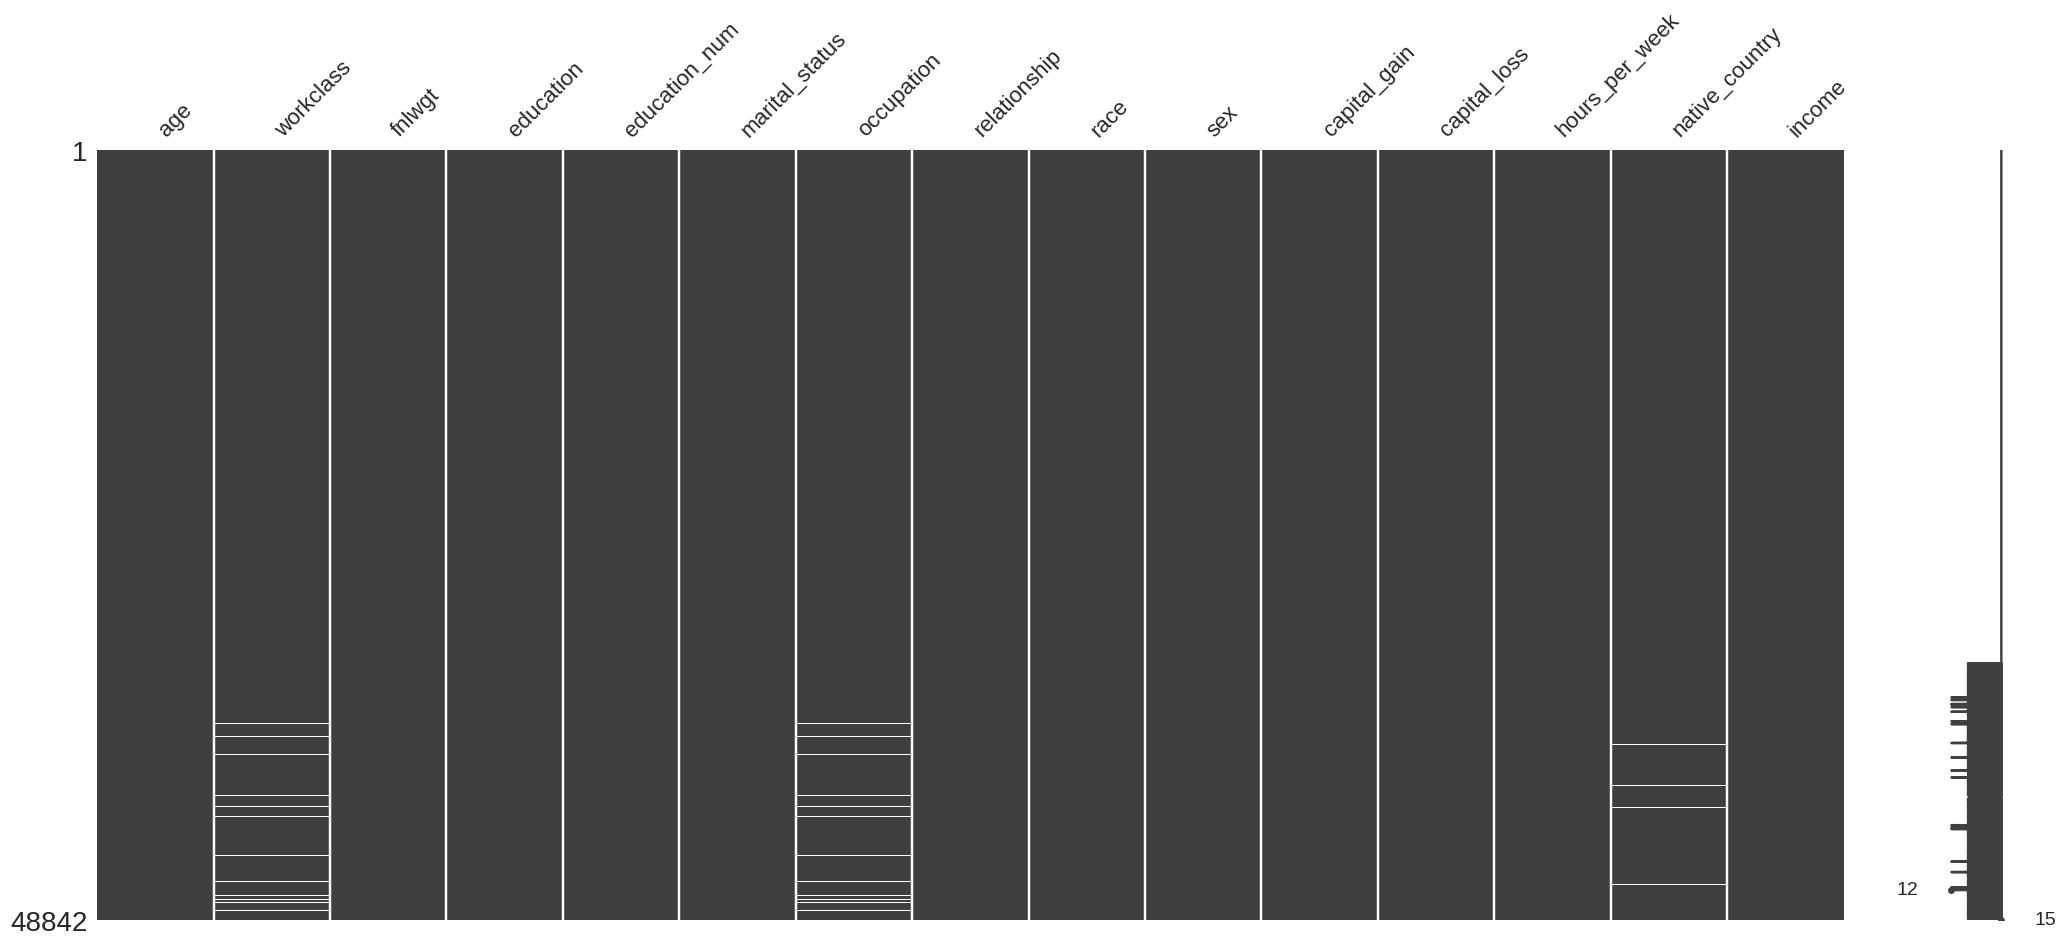

In [11]:
msno.matrix(data);

## EDA: Exploratory Data Analysis

In [12]:
data["income"].value_counts(normalize=False)

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

### Target

In [13]:
data = data.assign(income= lambda dfr: dfr.income.str.replace(".", ""))

In [14]:
label_distribution = data.groupby(['income']).size().reset_index(name='count')
label_distribution

income  count
0  <=50K  37155
1   >50K  11687

In [15]:
# Plot a pie chart with custom colors for income
fig = px.pie(
    label_distribution,
    names='income',  # Use 'income' for pie segments
    values='count',  # Use 'count' for the size of each pie slice
    # color='income',  # Color the segments based on income
    title='Income distribution',
    labels={'income': 'Income', 'count': 'Count'},
)

fig.update_traces(textinfo='percent+label')  # Display percentage and labels on the pie chart

fig.show()

### Categorical features

In [16]:
categorical_columns = data.select_dtypes(include="object").columns

categorical_columns

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income'],
      dtype='object')

In [17]:
for col_name in categorical_columns:
    logger.info(f"{col_name} ==============\n {data[col_name].value_counts(dropna=False)}\n")

2025-05-06 08:28:33.012 | INFO     | __main__:<cell line: 0>:2 - workclass ==============
 workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
NaN                   963
Without-pay            21
Never-worked           10
Name: count, dtype: int64

2025-05-06 08:28:33.027 | INFO     | __main__:<cell line: 0>:2 - education ==============
 education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

2025-05-06 08:28:33.037 | INFO     | __main__:<cell line: 0>:2 - marital_status ==============
 marital_status
Married-civ-spouse   

#### Preprocessing

In [18]:
# Replace “?” with None for all columns containing it
data.replace("?", None, inplace=True)

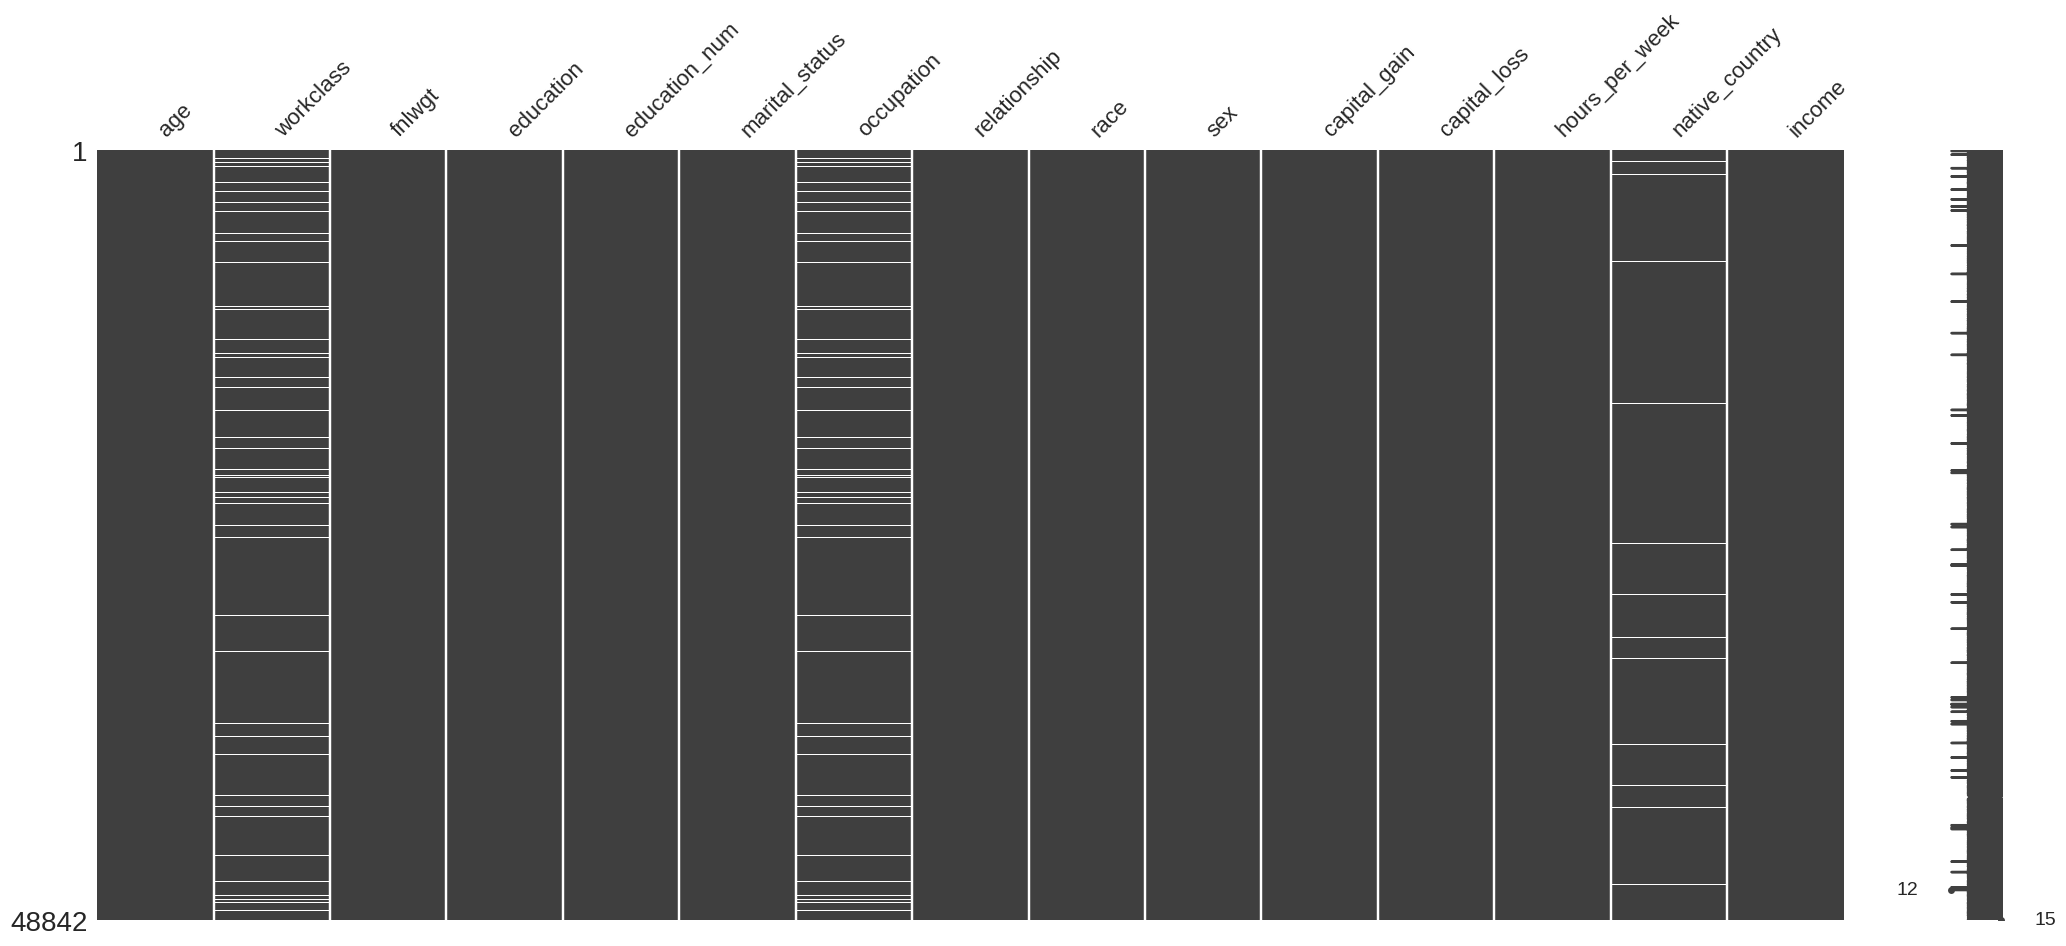

In [19]:
msno.matrix(data);

### Remove Duplicated

In [20]:
# Shape after deduplication
data.shape

(48842, 15)

In [21]:
# Check for the duplicates: if True then there are duplicated
data.duplicated().any()

np.True_

In [22]:
data[data.duplicated(keep=False)].sort_values(["workclass", "education", "relationship"])

age workclass  fnlwgt     education  education_num marital_status  \
24667   17   Private  153021          12th              8  Never-married   
36713   17   Private  153021          12th              8  Never-married   
5842    25   Private  195994       1st-4th              2  Never-married   
13084   25   Private  195994       1st-4th              2  Never-married   
22300   25   Private  195994       1st-4th              2  Never-married   
...    ...       ...     ...           ...            ...            ...   
38993   22       NaN  334593  Some-college             10  Never-married   
10094   19      None  167428  Some-college             10  Never-married   
30384   20      None  203353  Some-college             10  Never-married   
34424   20       NaN  203353  Some-college             10  Never-married   
40677   19       NaN  167428  Some-college             10  Never-married   

            occupation   relationship   race     sex  capital_gain  \
24667            Sales      Own-child  White  Female             0   
36713            Sales      Own-child  White  Female             0   
5842   Priv-house-serv  Not-in-family  White  Female             0   
13084  Priv-house-serv  Not-in-family  White  Female             0   
22300  Priv-house-serv  Not-in-family  White  Female             0   
...                ...            ...    ...     ...           ...   
38993              NaN  Not-in-family  White    Male             0   
10094             None      Own-child  White    Male             0   
30384             None      Own-child  White  Female             0   
34424              NaN      Own-child  White  Female             0   
40677              NaN      Own-child  White    Male             0   

       capital_loss  hours_per_week native_country income  
24667             0              20  United-States  <=50K  
36713             0              20  United-States  <=50K  
5842              0              40      Guatemala  <=50K  
13084             0              40      Guatemala  <=50K  
22300             0              40      Guatemala  <=50K  
...             ...             ...            ...    ...  
38993             0              40  United-States  <=50K  
10094             0              40  United-States  <=50K  
30384             0              40  United-States  <=50K  
34424             0              40  United-States  <=50K  
40677             0              40  United-States  <=50K  

[101 rows x 15 columns]

In [23]:
# Drop duplicates
data = data.drop_duplicates(keep='first', inplace=False)
data.shape

(48790, 15)

In [24]:
# Shape after deduplication
data.shape

(48790, 15)

### Numerical features

In [25]:
data["capital_diff"] = data['capital_gain'] - data['capital_loss']

<ipython-input-25-9c8a4d742987>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [27]:
# Initialize a figure
fig = go.Figure()

# Iterate over numeric columns in the DataFrame
for column in numeric_columns:
    fig.add_trace(go.Box(
        y=data[column],
        name=column,
        marker=dict(color='skyblue')
    ))

# Update layout with a title and axis labels
fig.update_layout(
    title='Distribution of Numeric Columns without Outliers',
    yaxis_title='Values',
    xaxis_title='Numeric Columns'
)

# Show the figure
fig.show()


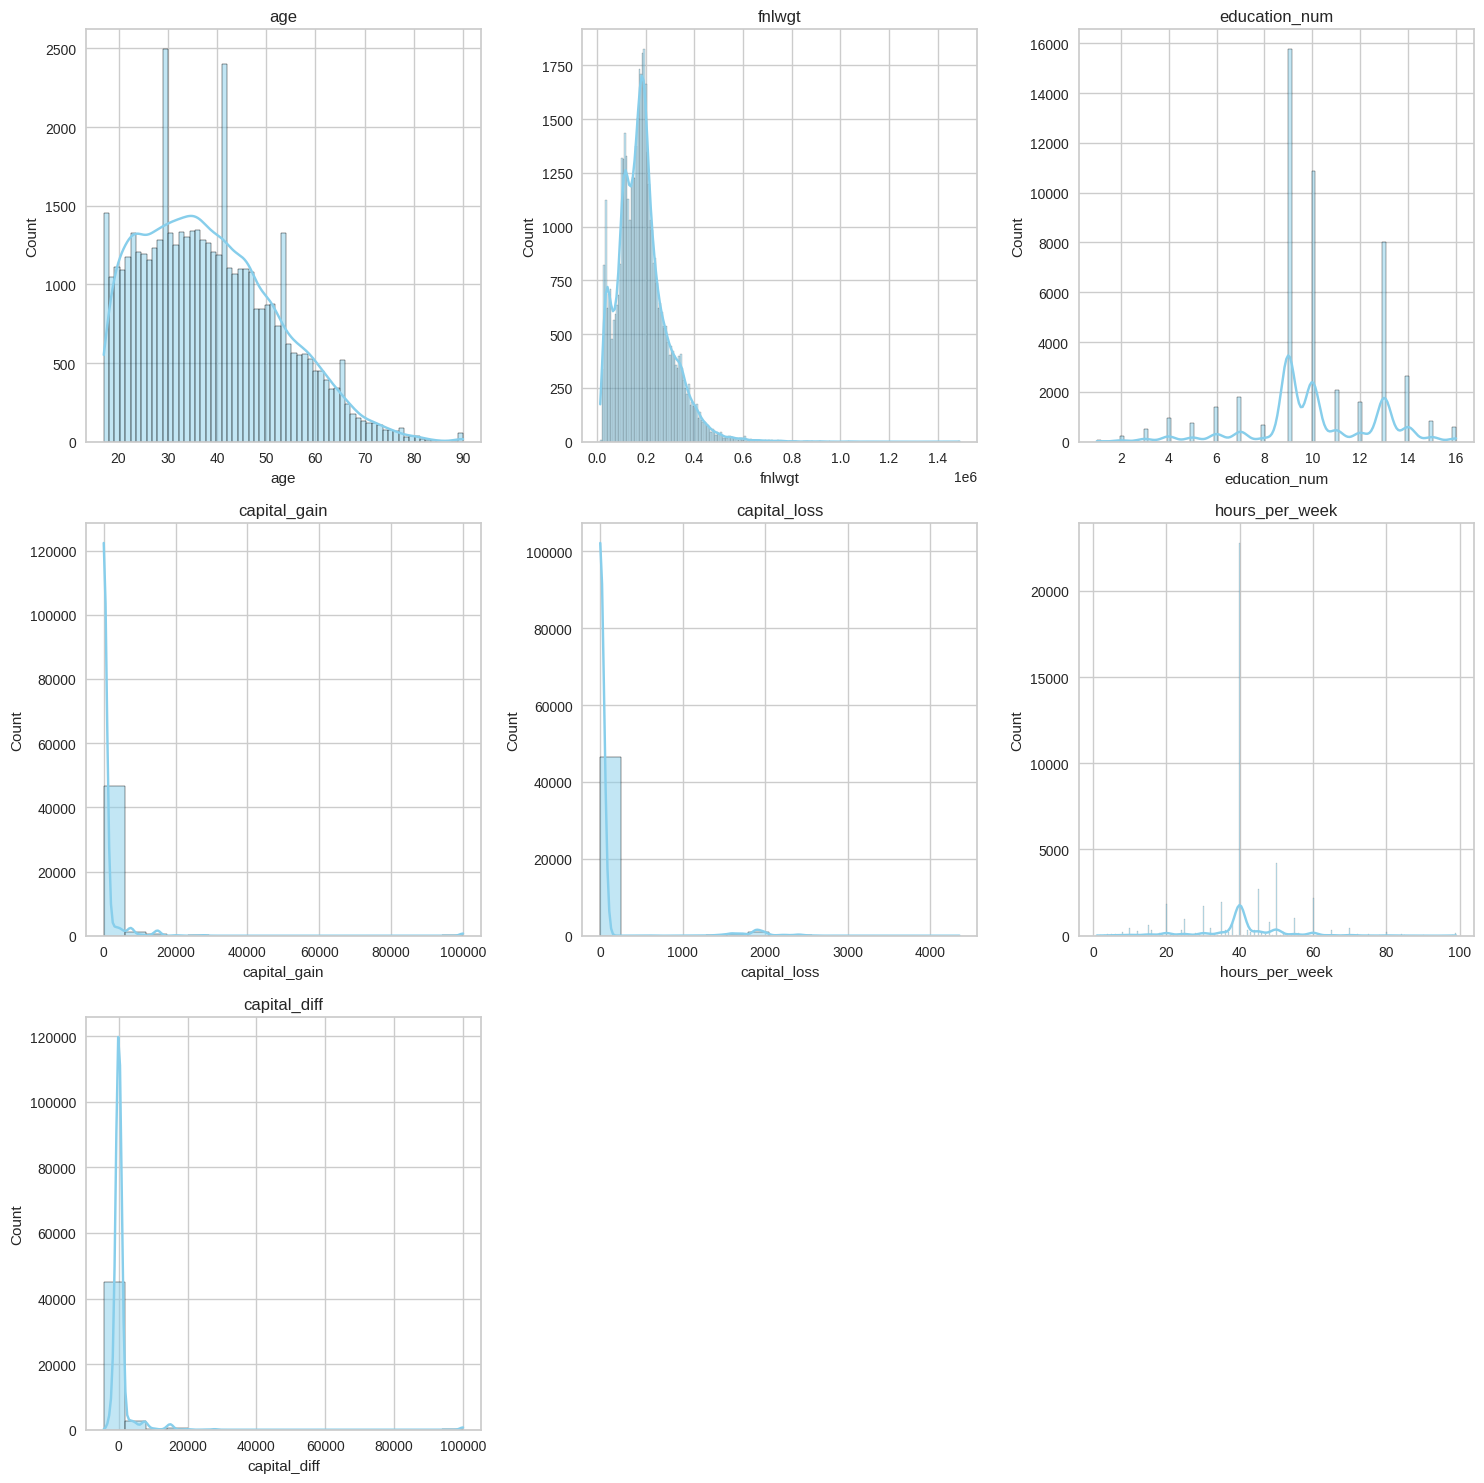

In [28]:
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(numeric_columns):
    sns.histplot(data[col_name], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col_name)

for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Bivariate analysis

In [29]:
px.box(
    data,
    x='income',  # Income category on the x-axis
    y='age',  # Age distribution on the y-axis
    title='Age Distribution by Income',
    labels={'income': 'Income Category', 'age': 'Age'}
)

In [30]:
data

age         workclass  fnlwgt  education  education_num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital_status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2                Divorced  Handlers-cleaners   Not-in-family   
3      Married-civ-spouse  Handlers-cleaners         Husband   
4      Married-civ-spouse     Prof-specialty            Wife   
...                   ...                ...             ...   
48837            Divorced     Prof-specialty   Not-in-family   
48838             Widowed                NaN  Other-relative   
48839  Married-civ-spouse     Prof-specialty         Husband   
48840            Divorced       Adm-clerical       Own-child   
48841  Married-civ-spouse    Exec-managerial         Husband   

                     race     sex  capital_gain  capital_loss  hours_per_week  \
0                   White    Male          2174             0              40   
1                   White    Male             0             0              13   
2                   White    Male             0             0              40   
3                   Black    Male             0             0              40   
4                   Black  Female             0             0              40   
...                   ...     ...           ...           ...             ...   
48837               White  Female             0             0              36   
48838               Black    Male             0             0              40   
48839               White    Male             0             0              50   
48840  Asian-Pac-Islander    Male          5455             0              40   
48841               White    Male             0             0              60   

      native_country income  capital_diff  
0      United-States  <=50K          2174  
1      United-States  <=50K             0  
2      United-States  <=50K             0  
3      United-States  <=50K             0  
4               Cuba  <=50K             0  
...              ...    ...           ...  
48837  United-States  <=50K             0  
48838  United-States  <=50K             0  
48839  United-States  <=50K             0  
48840  United-States  <=50K          5455  
48841  United-States   >50K             0  

[48790 rows x 16 columns]

In [31]:
for col_name in ["workclass",
                 "education",
                 "marital_status",
                 "sex"
                ]:

    feature_income_counts = data.groupby([col_name, 'income']).size().unstack()

    fig = px.bar(feature_income_counts,
                 barmode='stack',  # Stack bars for income categories
                 title=f'Relationship between Income and {col_name}',
                 labels={'value': 'Count'}
                )
    fig.show()

In [32]:
for col_name in numeric_columns:

    #counts
    num_feat_income_counts = data.groupby([col_name, "income"]).size().unstack()

    # Plot using iplot
    fig = px.area(num_feat_income_counts,
                  title=f"Relationship between {col_name} and income",
                  labels={"value": "Count"}
                 )
    fig.show()

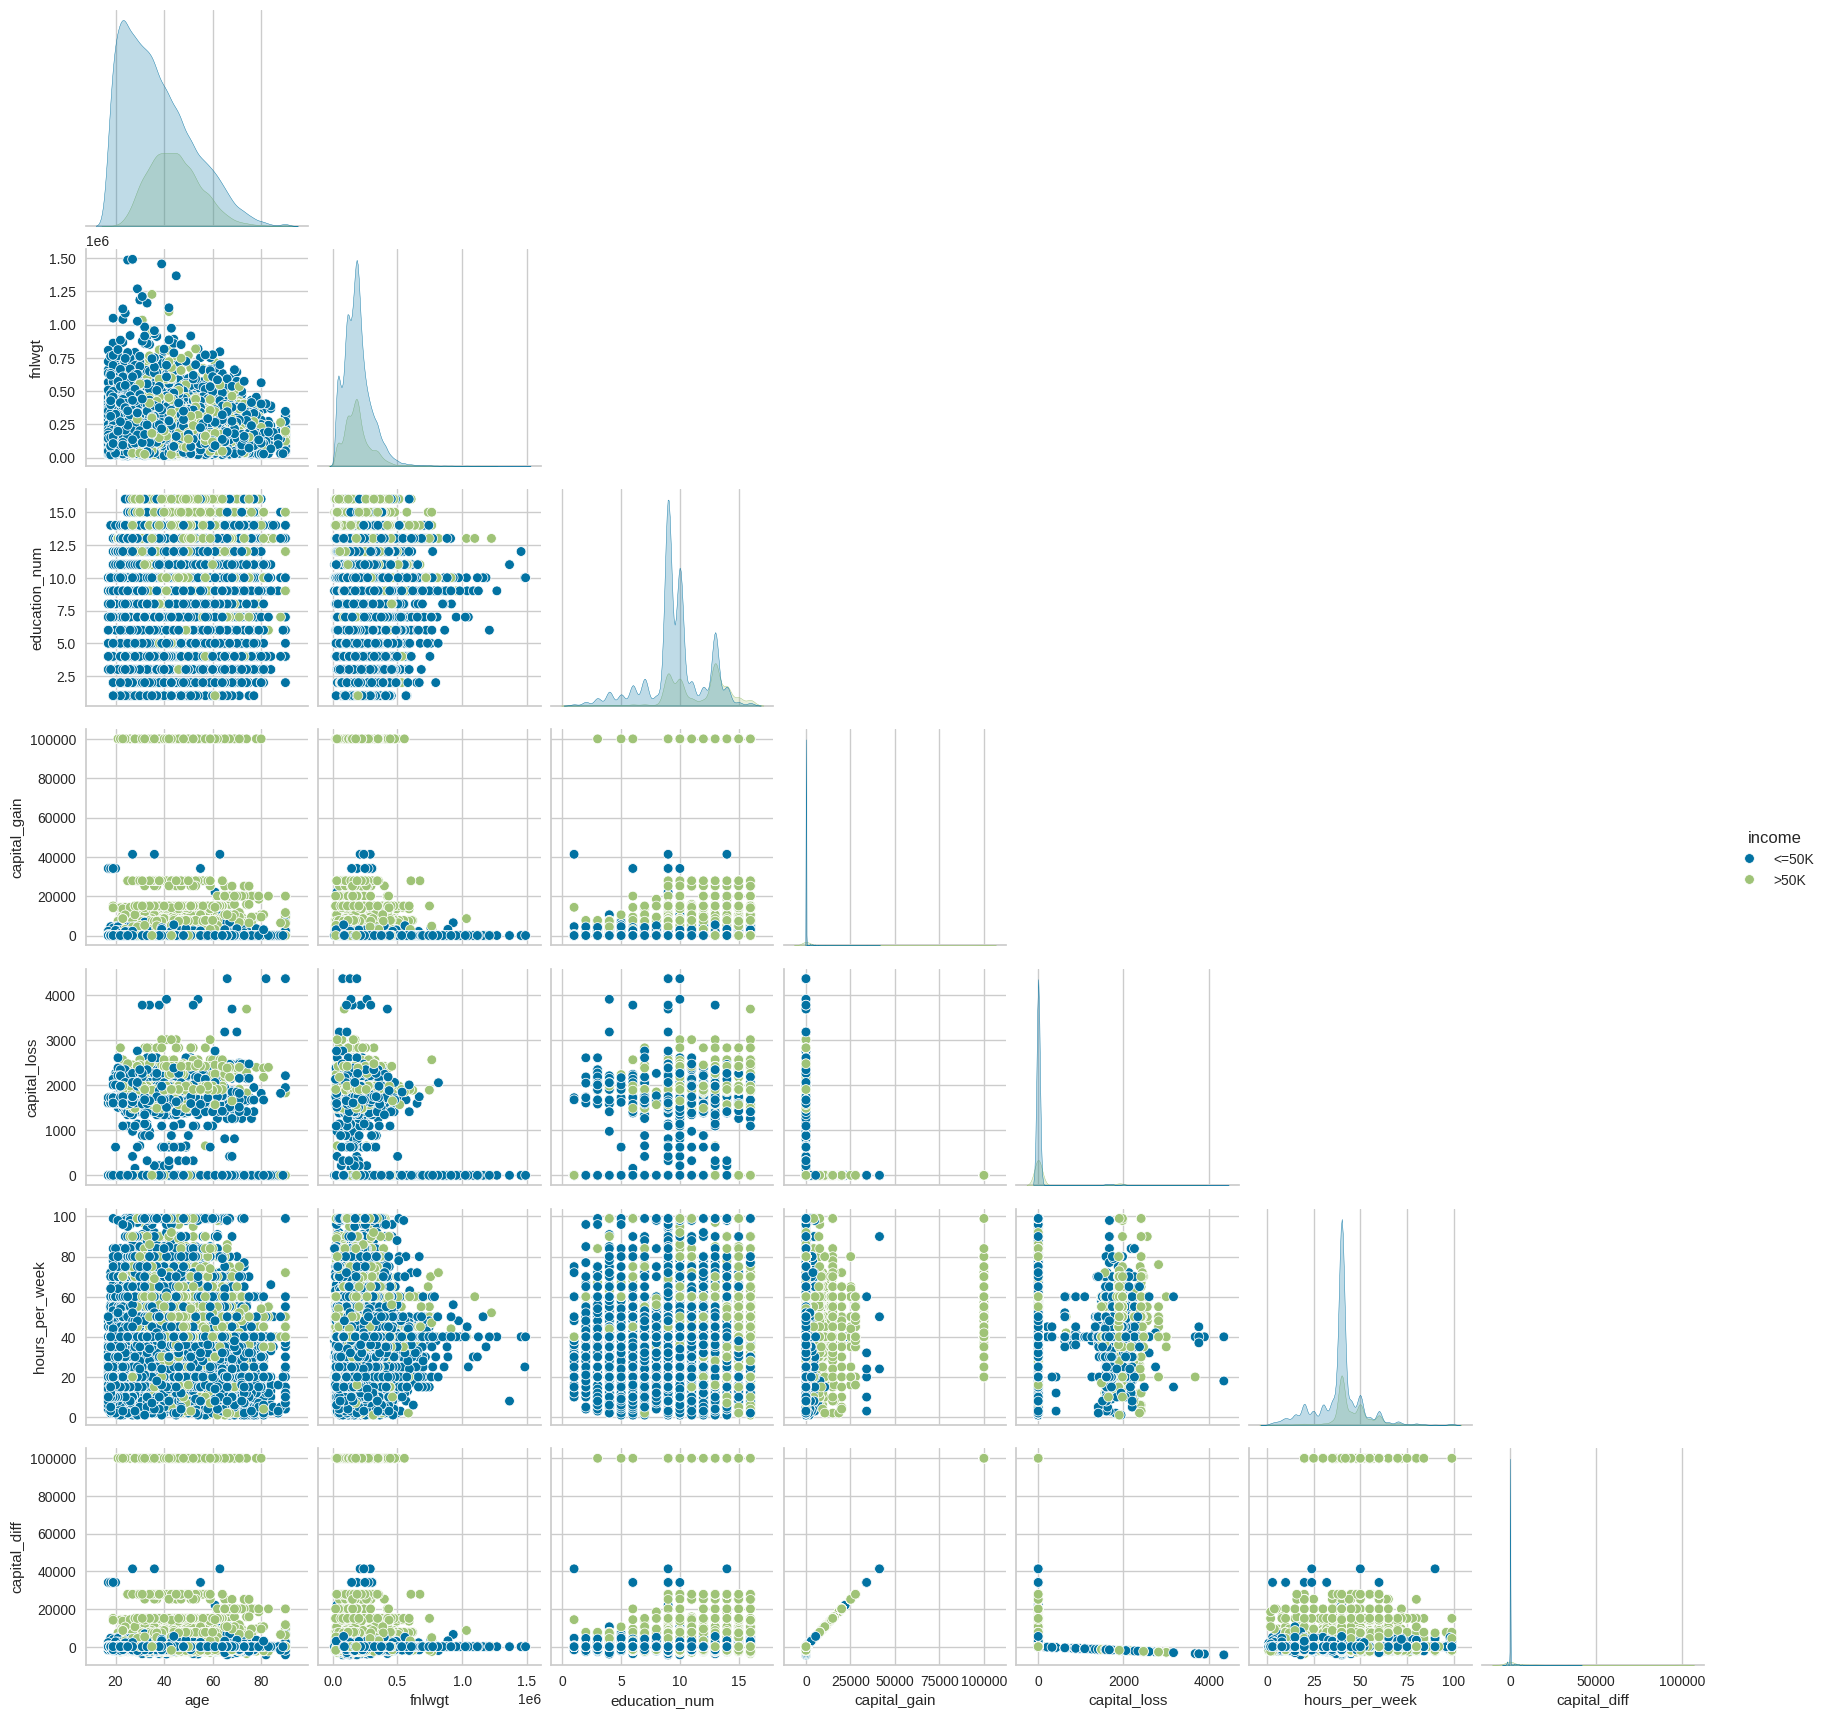

In [33]:
sns.pairplot(data, hue="income", corner=True);

### Correlation

In [34]:
corr_matrix = data.loc[:, numeric_columns].corr()


In [35]:
data.loc[:, numeric_columns].corr()

age    fnlwgt  education_num  capital_gain  capital_loss  \
age             1.000000 -0.076451       0.030635      0.077185      0.056838   
fnlwgt         -0.076451  1.000000      -0.038727     -0.003715     -0.004378   
education_num   0.030635 -0.038727       1.000000      0.125219      0.080986   
capital_gain    0.077185 -0.003715       0.125219      1.000000     -0.031475   
capital_loss    0.056838 -0.004378       0.080986     -0.031475      1.000000   
hours_per_week  0.071223 -0.013521       0.143915      0.082152      0.054431   
capital_diff    0.073878 -0.003467       0.120459      0.998547     -0.085285   

                hours_per_week  capital_diff  
age                   0.071223      0.073878  
fnlwgt               -0.013521     -0.003467  
education_num         0.143915      0.120459  
capital_gain          0.082152      0.998547  
capital_loss          0.054431     -0.085285  
hours_per_week        1.000000      0.078959  
capital_diff          0.078959      1.000000

<Axes: >

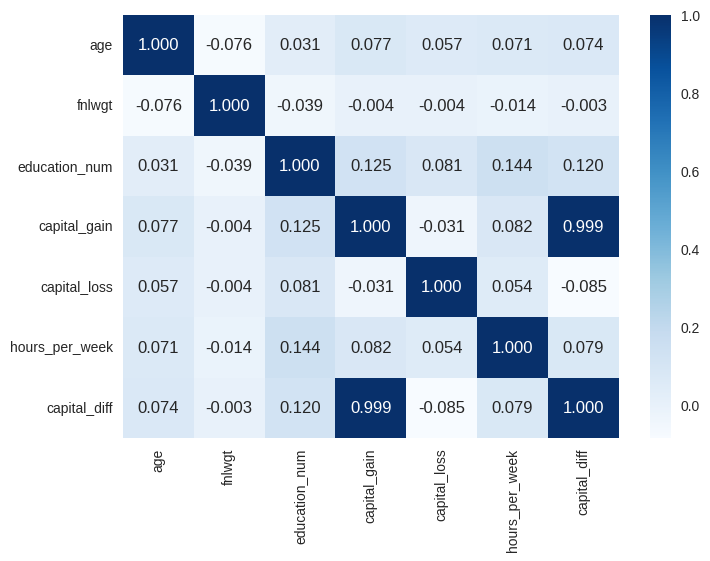

In [36]:
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="Blues")

## Data preparation

In [37]:
data.head()

age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  \
0          2174             0              40  United-States  <=50K   
1             0             0              13  United-States  <=50K   
2             0             0              40  United-States  <=50K   
3             0             0              40  United-States  <=50K   
4             0             0              40           Cuba  <=50K   

   capital_diff  
0          2174  
1             0  
2             0  
3             0  
4             0

In [38]:
# Removing rows where 'Workclass' is 'Without-pay' and 'Never-worked'
data = data[~data["workclass"].str.lower().isin(["without-pay", "never-worked"])
            # & data["hours_per_week"].between(20, 60)
           ]
data.shape

(48759, 16)

In [39]:
data["hours_per_week"].value_counts(sort=False).sort_index()

hours_per_week
1      27
2      53
3      59
4      83
5      95
     ... 
95      2
96      9
97      2
98     14
99    137
Name: count, Length: 96, dtype: int64

In [40]:
#Feature mapping
workclass_mapping = {
    'Private': 'Private',
    'Self-emp-not-inc': 'Self-Employed',
    'Local-gov': 'Government',
    'State-gov': 'Government',
    'Self-emp-inc': 'Self-Employed',
    'Federal-gov': 'Government',
    'Without-pay': 'Other',
    'Never-worked': 'Other'
}

marital_status_mapping = {
    "Married-civ-spouse": "Married",
    "Married-spouse-absent": "Married",
    "Married-AF-spouse": "Married",
    "Separated": "Married",
    "Never-married": "Single",
    "Divorced": "Single",
    "Widowed": "Single"
}

relationship_mapping = {
    'Husband': 'spouse',
    'Not-in-family': 'Others:',
    'Own-child': 'Immediate Family',
    'Unmarried': 'Others:',
    'Wife': 'spouse',
    'Other-relative': 'Immediate Family',
}

# occupation
# occupation_mapping = to be defined if necessary

In [41]:
data = data.assign(income=lambda dfr: dfr['income'].map({"<=50K": 0, ">50K": 1}),
                   # capital_diff_bin = lambda dfr: pd.cut(dfr['capital_diff'], bins = [-5000, 5000, 100000], labels = ['Low', 'High'])
                   native_country=lambda dfr: dfr["native_country"].fillna("United-States").map(lambda val: val if val == "United-States" else "Others"),
                   education=lambda dfr: dfr.education.replace(["11th", "9th", "7th-8th", "5th-6th", "10th", "1st-4th", "12th"], "School"),
                   race=lambda dfr: dfr.race.map(lambda val: 'White' if val == 'White' else 'Others'),
                   # workclass=lambda dfr: dfr.workclass.map(workclass_mapping),
                   # marital_status=lambda dfr: dfr.marital_status.map(marital_status_mapping),
                   # relationship=lambda dfr: dfr.relationship.map(relationship_mapping),
                  )

## Train / test split

In [42]:
data.drop(['capital_gain',
           'capital_loss',
           "fnlwgt",  # fnlwgt (Final Weight): Represents the weight assigned to each individual.
           "education_num",
       ], axis=1, inplace=True)


In [43]:
x_values = data.drop(columns=['income'])
y_target = data.income

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x_values, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [45]:
x_train.head()

age         workclass     education      marital_status  \
44101   35         Local-gov     Bachelors  Married-civ-spouse   
36845   61           Private       HS-grad            Divorced   
44706   41           Private  Some-college            Divorced   
35127   49  Self-emp-not-inc        School  Married-civ-spouse   
41678   37  Self-emp-not-inc     Assoc-voc  Married-civ-spouse   

              occupation   relationship   race     sex  hours_per_week  \
44101    Protective-serv        Husband  White    Male              48   
36845  Machine-op-inspct  Not-in-family  White  Female              40   
44706              Sales      Unmarried  White    Male              46   
35127    Farming-fishing        Husband  White    Male              50   
41678    Farming-fishing        Husband  White    Male              60   

      native_country  capital_diff  
44101  United-States             0  
36845  United-States             0  
44706  United-States             0  
35127  United-States             0  
41678  United-States             0

In [46]:
y_train.value_counts(normalize=True).mul(100).round(2)

income
0    76.05
1    23.95
Name: proportion, dtype: float64

In [47]:
y_train.value_counts(normalize=True).mul(100).round(2)

income
0    76.05
1    23.95
Name: proportion, dtype: float64

### Feature engineering

In [48]:
x_values.head()

age         workclass  education      marital_status         occupation  \
0   39         State-gov  Bachelors       Never-married       Adm-clerical   
1   50  Self-emp-not-inc  Bachelors  Married-civ-spouse    Exec-managerial   
2   38           Private    HS-grad            Divorced  Handlers-cleaners   
3   53           Private     School  Married-civ-spouse  Handlers-cleaners   
4   28           Private  Bachelors  Married-civ-spouse     Prof-specialty   

    relationship    race     sex  hours_per_week native_country  capital_diff  
0  Not-in-family   White    Male              40  United-States          2174  
1        Husband   White    Male              13  United-States             0  
2  Not-in-family   White    Male              40  United-States             0  
3        Husband  Others    Male              40  United-States             0  
4           Wife  Others  Female              40         Others             0

In [49]:
# numerical
numeric_features = x_values.select_dtypes(include="number").columns

# categorical
onehot_features = ['workclass', 'occupation', 'relationship', 'race', 'sex', 'marital_status']

country_feature = ["native_country"]
ordinal_features = ['education',
                   # 'capital_diff_bin',
                  ]

cat_for_edu = ['Preschool', 'School', 'HS-grad','Some-college', 'Assoc-voc', 'Assoc-acdm','Bachelors', 'Masters', 'Prof-school', 'Doctorate']
cat_for_capdiff = ['Low', 'High']

In [50]:
x_train.loc[:, numeric_features]

age  hours_per_week  capital_diff
44101   35              48             0
36845   61              40             0
44706   41              46             0
35127   49              50             0
41678   37              60             0
...    ...             ...           ...
2324    63              50             0
30520   21              40             0
42196   60              25             0
41858   34              40             0
26127   19              35             0

[39007 rows x 3 columns]

In [51]:
x_train.loc[:, numeric_features]

age  hours_per_week  capital_diff
44101   35              48             0
36845   61              40             0
44706   41              46             0
35127   49              50             0
41678   37              60             0
...    ...             ...           ...
2324    63              50             0
30520   21              40             0
42196   60              25             0
41858   34              40             0
26127   19              35             0

[39007 rows x 3 columns]

In [52]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# Education : ordinal + imputation 'undefined' gérée via catégorie manquante
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('ordinal', OrdinalEncoder(categories=[cat_for_edu + ['undefined']], handle_unknown='use_encoded_value', unknown_value=-1))
])

# OneHot : autres variables catégorielles avec imputation "undefined"
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Native country : imputation avec "United-States"
country_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='United-States')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('ord', ordinal_transformer, ordinal_features),
    ('cat', onehot_transformer, onehot_features),
    ('country', country_transformer, country_feature)
])



preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='undefined',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Preschool',
                                                                              'School',
                                                                              'HS-...
                                                  SimpleImputer(fill_value='undefined',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['workclass', 'occupation', 'relationship',
                                  'race', 'sex', 'marital_status']),
                                ('country',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='United-States',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['native_country'])])

## Modeling

#### Dummy regressor

In [53]:
# Pipeline
dm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DummyClassifier())
])

dm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', DummyClassifier())])

In [91]:
# Training
dm_pipeline.fit(x_train, y_train)

# Predictions & evaluation
dm_y_pred_test = dm_pipeline.predict(x_test)
dm_y_proba_test = dm_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, dm_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, dm_y_pred_test)}")

2025-04-28 15:19:05.487 | INFO     | __main__:<cell line: 0>:9 - AUC: 0.50
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2025-04-28 15:19:05.516 | INFO     | __main__:<cell line: 0>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.76      1.00      0.8

#### Logistic regression

In [92]:
# Pipeline
rl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

rl_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', LogisticRegression(max_iter=1000))])

##### Baseline

In [93]:
# 8. Entraînement
rl_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
rl_y_pred_test = rl_pipeline.predict(x_test)
rl_y_proba_test = rl_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, rl_y_proba_test):.2f} ")

logger.info(f"Classification report: \n{classification_report(y_test, rl_y_pred_test)}")

2025-04-28 15:21:24.566 | INFO     | __main__:<cell line: 0>:9 - AUC: 0.90 
2025-04-28 15:21:24.582 | INFO     | __main__:<cell line: 0>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7416
           1       0.72      0.59      0.65      2336

    accuracy                           0.85      9752
   macro avg       0.80      0.76      0.78      9752
weighted avg       0.84      0.85      0.84      9752



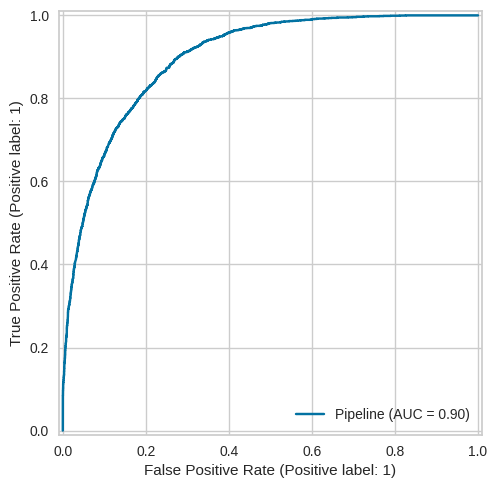

In [94]:
RocCurveDisplay.from_estimator(rl_pipeline, x_test, y_test);

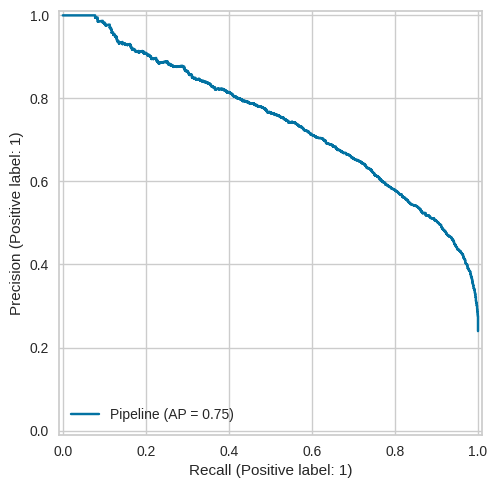

In [95]:
PrecisionRecallDisplay.from_estimator(rl_pipeline, x_test, y_test);


##### Tuning hyperparameters

In [96]:
rl_param_grid = {
    "clf__penalty": ["l2"],  # 'l1' si solver = 'liblinear' ou 'saga'
    "clf__C": [0.01, 0.1, 1, 2, 3, 5, 10],
    "clf__solver": ['liblinear', 'lbfgs', "sag", "saga"],  # lbfgs ne supporte que l2
    "clf__class_weight": ['balanced', None],
}

In [97]:
# Cross-validation
cv = StratifiedKFold(n_splits=5)

rl_grid_search = GridSearchCV(rl_pipeline, rl_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Training
rl_grid_search.fit(x_train, y_train)

# Best params
logger.info(f"Best params : {rl_grid_search.best_params_}")

# Evaluation
rl_y_pred_test_opt = rl_grid_search.predict(x_test)
rl_y_proba_test_opt  = rl_grid_search.predict_proba(x_test)[:, 1]

logger.info(f"AUC : {roc_auc_score(y_test, rl_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, rl_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, rl_y_pred_test_opt):.2f}")


2025-04-28 15:45:12.677 | INFO     | __main__:<cell line: 0>:10 - Best params : {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
2025-04-28 15:45:12.765 | INFO     | __main__:<cell line: 0>:16 - AUC : 0.90
2025-04-28 15:45:12.773 | INFO     | __main__:<cell line: 0>:17 - F1-score : 0.66
2025-04-28 15:45:12.776 | INFO     | __main__:<cell line: 0>:18 - Accuracy : 0.79


##### Discrimination threshold

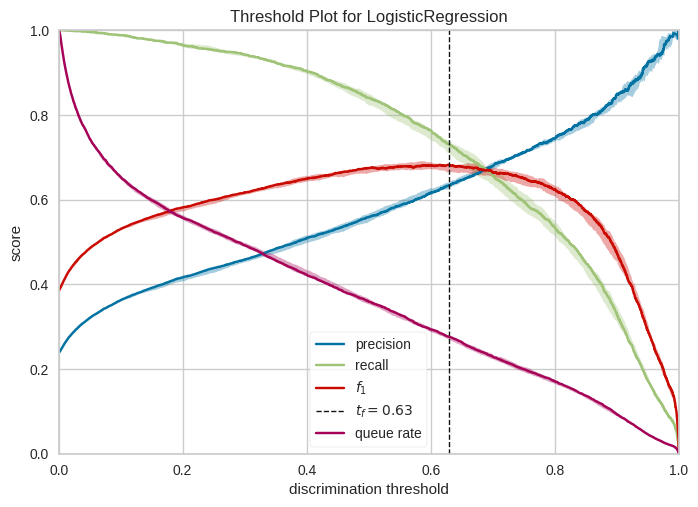

In [98]:
viz = DiscriminationThreshold(rl_grid_search.best_estimator_, random_state=42, fbeta=1.0, cv=cv, argmax="fscore")

# Fit et plot
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show();

In [99]:
threshold = 0.75
y_pred_custom = (rl_grid_search.best_estimator_.predict_proba(x_test)[:, 1] >= threshold).astype(int)
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.7039
Recall: 0.6117
F1 Score: 0.6546


#### Random forest

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

##### Pipeline

In [73]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', RandomForestClassifier(random_state=42))])

##### Cross validation search

In [74]:

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__min_samples_split': [2, 5, 10]
}

rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=10,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_search.fit(x_train, y_train)
best_rf_pipeline = rf_search.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


##### Classification report

In [75]:
from sklearn.metrics import classification_report

y_pred_rf = best_rf_pipeline.predict(x_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      7416
           1       0.76      0.62      0.68      2336

    accuracy                           0.86      9752
   macro avg       0.83      0.78      0.80      9752
weighted avg       0.86      0.86      0.86      9752



##### Features importance

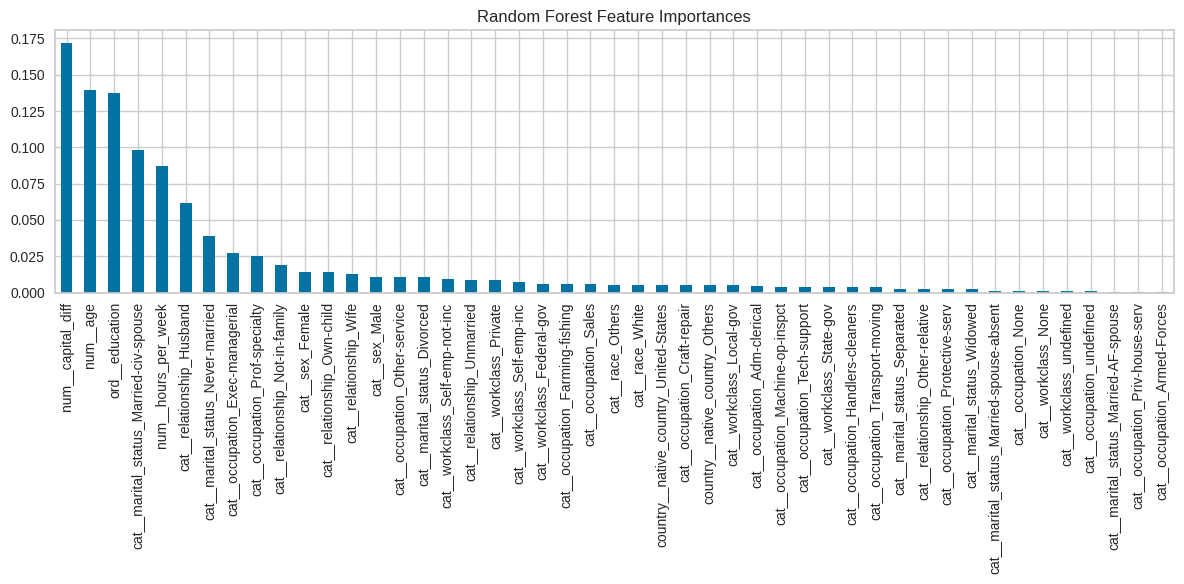

In [77]:
best_rf_model = best_rf_pipeline.named_steps['clf']
rf_feature_names = best_rf_pipeline.named_steps['preprocessor'].get_feature_names_out(x_train.columns)

importances_rf = pd.Series(best_rf_model.feature_importances_, index=rf_feature_names)

# Plot
importances_rf.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Random Forest Feature Importances')
plt.tight_layout()
plt.show()


#### XGBoost

##### Pipeline

In [66]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

##### Cross validation search

In [67]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6, 10],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__subsample': [0.7, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_search.fit(x_train, y_train)
best_xgb_pipeline = xgb_search.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[08:49:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




##### Classification report

In [68]:
from sklearn.metrics import classification_report

y_pred = best_xgb_pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7416
           1       0.77      0.67      0.72      2336

    accuracy                           0.87      9752
   macro avg       0.84      0.80      0.82      9752
weighted avg       0.87      0.87      0.87      9752



##### Feature importance

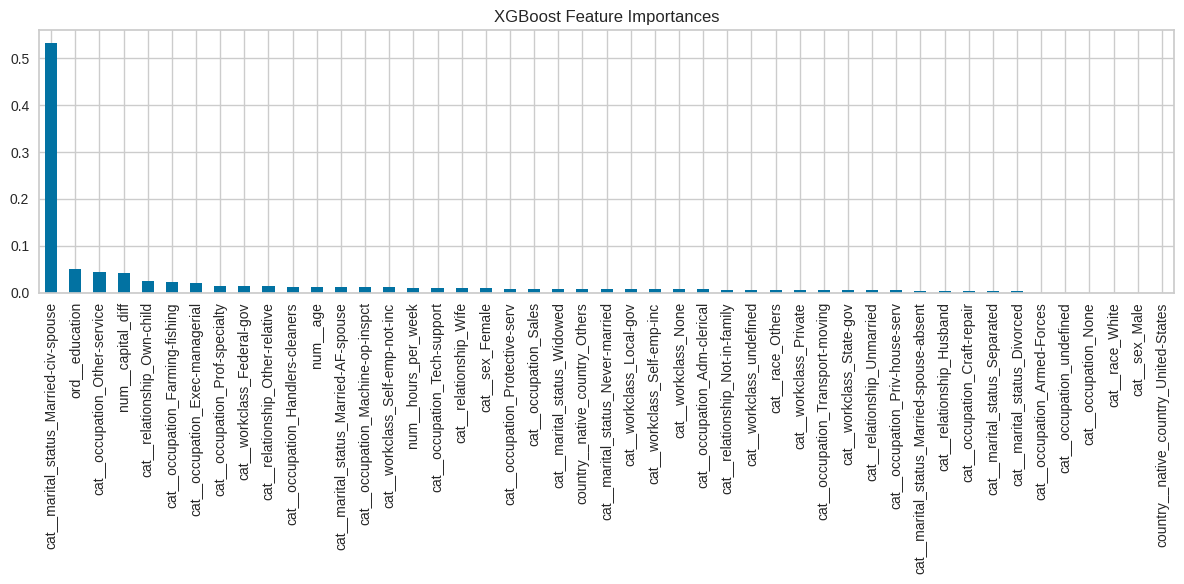

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

best_model = best_xgb_pipeline.named_steps['clf']

feature_names = best_xgb_pipeline.named_steps['preprocessor'].get_feature_names_out(x_train.columns)

importances = pd.Series(best_model.feature_importances_, index=feature_names)

# Plot
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='XGBoost Feature Importances')
plt.tight_layout()
plt.show()


In [71]:
best_model = best_xgb_pipeline.named_steps['clf']

print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


In [78]:
with open('best_xgb_pipeline.dill', 'wb') as f:
    dill.dump(best_xgb_pipeline, f)

# Save Random Forest pipeline
with open('best_rf_pipeline.dill', 'wb') as f:
    dill.dump(best_rf_pipeline, f)

##### Model analysis

In [ ]:
# features importances

##### Save model

In [ ]:
# Save model

model_path_name = Path(MODEL_DIR, "best_logistic_model.dill")

logger.info(f"Model path name: {model_path_name}")
with open(model_path_name, "wb") as fp:
    dill.dump(rl_grid_search.best_estimator_, fp)

2025-04-17 07:53:32.613 | INFO     | __main__:<module>:5 - Model path name: /Users/mouslydiaw/Documents/ml-courses/classification/models/best_logistic_model.dill


### KNN

#### Baseline

In [ ]:
# Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=10))
])

knn_pipeline

In [ ]:
# 8. Entraînement
knn_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
knn_y_pred_test = knn_pipeline.predict(x_test)
knn_y_proba_test = knn_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, knn_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, knn_y_pred_test)}")

In [ ]:
ConfusionMatrixDisplay.from_estimator(knn_pipeline, x_test, y_test,
                                      display_labels=class_names,
                                      normalize="true", cmap=plt.cm.Blues);

In [ ]:
RocCurveDisplay.from_estimator(knn_pipeline, x_test, y_test);